# 状態空間モデル

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import requests
import io
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import minimize
from pykalman import KalmanFilter

# 状態空間モデルを構築するのに必要な関数をインポート
from state_space_utils import *

In [2]:
%matplotlib inline

## パラメータの設定

In [3]:
np.set_printoptions(linewidth=1000, precision=2, floatmode='fixed', suppress=True)

result_dir_path = Path('result')
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

## データの取得

In [4]:
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
passengers = pd.read_csv(io.StringIO(stream.decode('utf-8')))

In [6]:
passengers.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<AxesSubplot:>

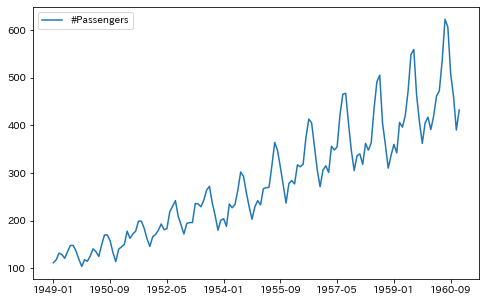

In [7]:
passengers.plot(
    x='Month',
    y='#Passengers', 
    figsize=(8, 5),
    xlabel=''
)

## データの加工

In [8]:
y = pd.Series(
    passengers['#Passengers'].values, 
    index=pd.to_datetime(passengers['Month'], infer_datetime_format=True)
)
y = y.astype(float)

n_train = 120
train_data, test_data = y.values[:n_train], y.values[n_train:]

##  トレンド推定モデル

### パラメータの設定

In [10]:
n_dim_obs = 1                  # 観測値の次元数
n_dim_trend = 2                # トレンドの次元数（状態の次元数）
n_dim_state = n_dim_trend

F = np.array([
    [2, -1],
    [1, 0]
], dtype=float)

G = np.array([
    [1],
    [0]
], dtype=float)

H = np.array([
    [1, 0]
], dtype=float)

Q = np.eye(1) * 10
Q = G.dot(Q).dot(G.T)

state_mean = np.zeros(n_dim_state)              # 状態の平均値ベクトルの初期値
state_cov = np.ones((n_dim_state, n_dim_state)) # 状態の分散共分散行列の初期値

### トレンド推定モデルの構築

In [11]:
kf = KalmanFilter(
    n_dim_obs=n_dim_obs,
    n_dim_state=n_dim_state,
    initial_state_mean=state_mean,
    initial_state_covariance=state_cov,
    transition_matrices=F,
    transition_covariance=Q,
    observation_matrices=H,
    observation_covariance=1.0,
)

### 平滑化

In [12]:
state_means, state_covs = kf.smooth(train_data)

In [13]:
print('状態の平均値 : \n{} \n\n 状態の共分散 : \n{}'.format(
    state_means[:4],
    state_covs[:4]
))

状態の平均値 : 
[[ 59.91  59.91]
 [109.58  59.91]
 [130.65 109.58]
 [129.08 130.65]] 

 状態の共分散 : 
[[[0.47 0.47]
  [0.47 0.47]]

 [[0.68 0.09]
  [0.09 0.47]]

 [[0.71 0.16]
  [0.16 0.68]]

 [[0.71 0.17]
  [0.17 0.71]]]


In [14]:
ovsevation_means_predicted = np.dot(state_means, kf.observation_matrices.T)

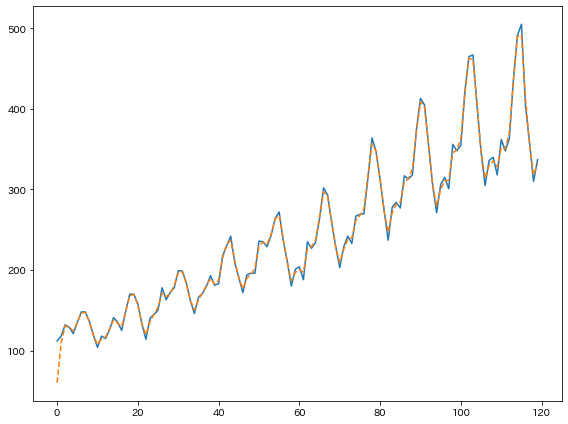

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(train_data, label="observation")
plt.plot(ovsevation_means_predicted, '--', label="forecast")
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('passenger_trend_smooth.png'))

### 予測

In [16]:
train_data, test_data = y[:n_train], y[n_train:]
    
state_means, state_covs = kf.smooth(train_data)
ovsevation_means_predicted = np.dot(state_means, kf.observation_matrices.T)

current_state = state_means[-1]
current_cov = state_covs[-1]

pred_means = np.array([])
for i in range(len(test_data)):

    current_state, current_cov = kf.filter_update(
        current_state, current_cov, observation=None
    )
    pred_mean = kf.observation_matrices.dot(current_state)
    pred_means = np.r_[pred_means, pred_mean]

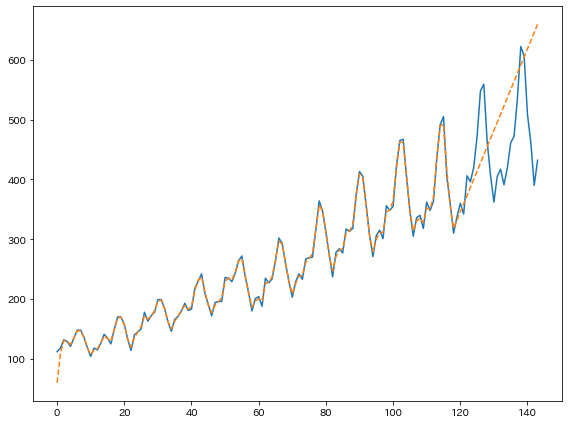

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(y.values, label="observation")
plt.plot(
    np.hstack([
        ovsevation_means_predicted.flatten(), 
        np.array(pred_means).flatten()
    ]), 
    '--', label="forecast"
)
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('passenger_trend_predict.png'))

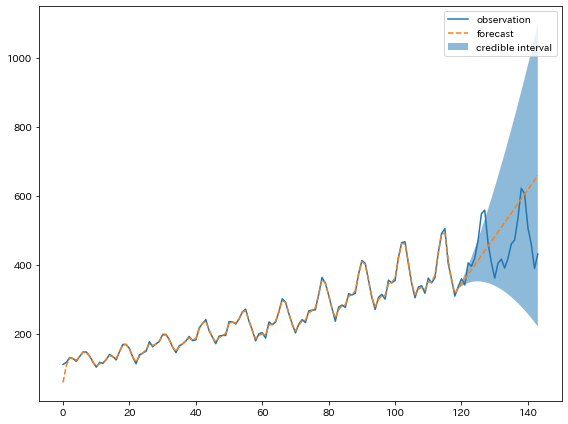

In [18]:
plot_state_space_model_pred(
    kf=kf, y=y.values, n_train=n_train, credible_interval=True,
    img_file_path=result_dir_path.joinpath('passenger_trend_predict.png')
)

## トレンド、季節周期、ARを状態とする状態空間モデル

In [29]:
n_dim_obs = 1
n_dim_trend = 2
n_dim_series = 12
n_dim_ar = 2

F, H, Q, n_dim_state = set_state_space_model_matrixes(
    n_dim_trend=n_dim_trend, 
    n_dim_obs=n_dim_obs, 
    n_dim_series=n_dim_series, 
    n_dim_ar=n_dim_ar
)

In [30]:
kf = KalmanFilter(
    n_dim_obs=n_dim_obs,
    n_dim_state=n_dim_state,
    initial_state_mean=np.zeros(n_dim_state),
    initial_state_covariance=np.ones((n_dim_state, n_dim_state)),
    transition_matrices=F,
    observation_matrices=H,
    observation_covariance=1.0,
    transition_covariance=Q
)

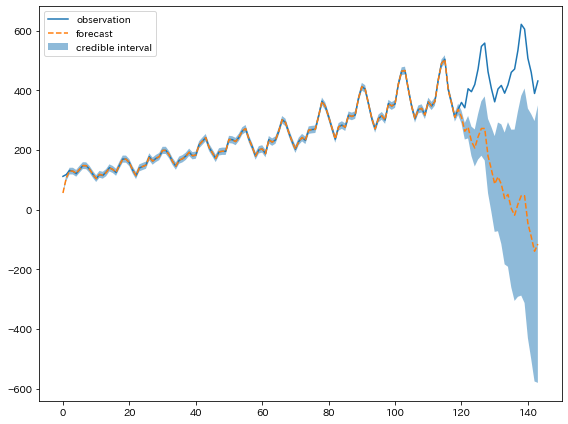

In [31]:
plot_state_space_model_pred(
    kf=kf, y=y.values, n_train=n_train,
    img_file_path=result_dir_path.joinpath('passenger_ar_predict.png')
)

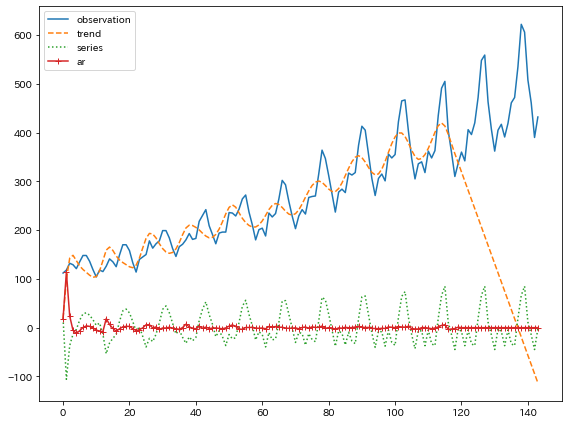

In [32]:
plot_state_space_model_process(
    kf=kf, y=y.values, n_train=n_train, 
    n_dim_trend=n_dim_trend,
    n_dim_series=n_dim_series,
    n_dim_ar=n_dim_ar,
    img_file_path=result_dir_path.joinpath('passenger_ar_process.png')
)

### パラメータの最適化

In [35]:
index_series_end = n_dim_trend + n_dim_series - 1

n_iter = 5
n_q = 2
bounds_ar = ((-0.95, 0.95), )
bounds_q = ((1e-4, 1e3), ) * (n_q) + ((1e-4, 5e1), )

kf_copy = copy.deepcopy(kf)

for index_ar in tqdm(range(n_dim_ar)):
    
    index_ar_end = index_series_end + index_ar
    
    for loop in range(n_iter):
        
        if index_ar > 0:
            ar_matrix = kf_copy.transition_matrices[index_series_end, index_series_end:index_ar_end]
            ar_cov = [
                kf_copy.transition_covariance[index_series_end + i, index_series_end + i] for i in range(index_ar)
            ]
            
        if loop == 0:
            kf_copy = copy.deepcopy(kf)
            
        if index_ar > 0:
            kf_copy.transition_matrices[index_series_end, index_series_end:index_ar_end] = ar_matrix
            for i in range(index_ar):
                kf_copy.transition_covariance[index_series_end + i, index_series_end + i] = ar_cov[i]

                
        minimize(
            minimize_likelihood_ar_matrix, 
            (0.,), 
            args=(kf_copy, train_data, index_ar, index_series_end), 
            method='SLSQP', 
            bounds=bounds_ar
        )

        cov_indexes = [index_series_end, n_dim_trend, 0]
        for i, index in enumerate(cov_indexes):
            
            minimize(
                minimize_likelihood_q, 
                (0., ), 
                args=(kf_copy, train_data, index), 
                method='SLSQP', 
                bounds=(bounds_q[len(cov_indexes) - i - 1], )
            )

        
        if index_ar == 0:
            kf_copy.transition_matrices[index_series_end, index_series_end] = ar_coef(
                kf_copy.transition_matrices[index_series_end, index_series_end], 1
            )
        else:
            kf_copy.transition_matrices[index_series_end, index_series_end:index_ar_end + 1] = ar_coef(
                kf_copy.transition_matrices[index_series_end, index_series_end:index_ar_end + 1],
                index_ar + 1
            )

100%|██████████| 2/2 [02:23<00:00, 71.60s/it]


In [36]:
opt_kf = copy.deepcopy(kf_copy)

ARの遷移行列

In [37]:
opt_kf.transition_matrices[index_series_end: , index_series_end:]

array([[0.95, 0.06],
       [1.00, 0.00]])

共分散行列の遷移行列

In [38]:
np.diag(opt_kf.transition_covariance)

array([   0.00,    0.00, 1000.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,   50.00,    0.00])

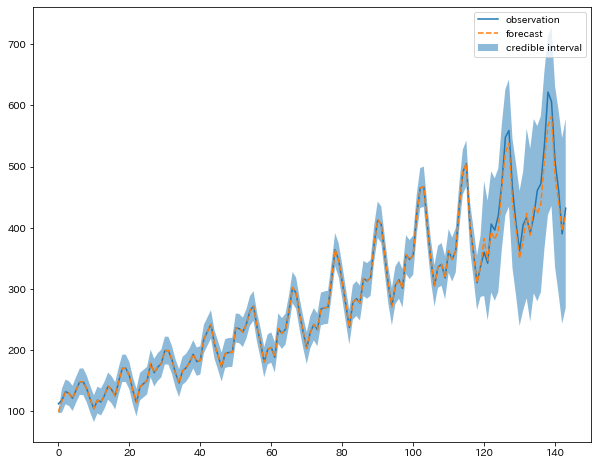

In [39]:
plot_state_space_model_pred(
    kf=opt_kf, y=y.values, n_train=n_train,
    img_file_path=result_dir_path.joinpath('passenger_ar_opt_predict.png')
)

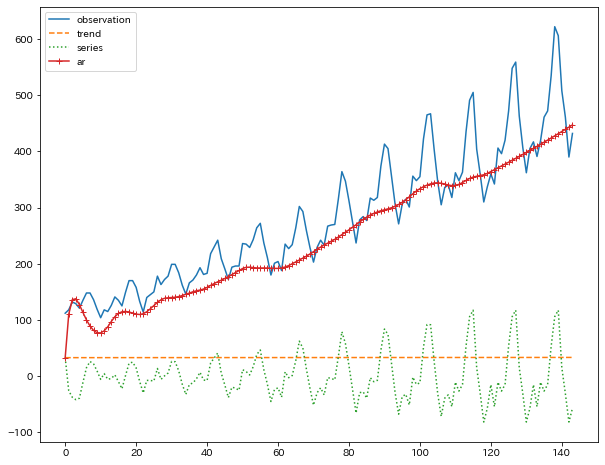

In [40]:
plot_state_space_model_process(
    kf=opt_kf, y=y.values, n_train=n_train, 
    n_dim_trend=n_dim_trend,
    n_dim_series=n_dim_series,
    n_dim_ar=n_dim_ar,
    img_file_path=result_dir_path.joinpath('passenger_ar_opt_process.png')
)